# 3.3 신경망 모델 구현하기
3.3.2 간단한 분류 모델 구현하기 

In [1]:
import torch
import numpy  #numpy는 수치해석용 라이브러리
from sklearn.datasets import make_blobs  #사이킷런은 파이썬의 대표적인 머신러닝 라이브러리
import matplotlib.pyplot as plt  #학습 데이터의 분포와 패턴을 시각화

# 학습 데이터를 만드는 데 넘파이와 사이킷런을 사용할것임

In [2]:
#신경망의 학습과 평가에 사용할 데이터셋 만들기
#make_blobs()는 예제용 데이터셋을 만들어주는 함수

n_dim = 2

#x_train , y_train 데이터셋은 신경망 학습에 쓰이는 데이터와 레이블
#n_sample : 표본 데이터 수, centers : 클러스터 수 혹은 중심, cluster_std : 클러스터 표준 편차
x_train, y_train = make_blobs(n_samples = 80, n_features = n_dim, centers =[[1,1],[-1,-1],[1,-1],[-1,1]], shuffle = True, cluster_std = 0.3)

#x_test , y_test 데이터셋은 학습이 끝난 신경망의 성능을 평가, 실험에 쓰임
x_test, y_test = make_blobs(n_samples = 20, n_features = n_dim, centers =[[1,1],[-1,-1],[1,-1],[-1,1]], shuffle = True, cluster_std = 0.3)

In [3]:
print(x_train)

[[-1.24538952 -1.80232207]
 [ 0.96364601 -0.76804292]
 [-0.64933493  0.88680604]
 [-0.93368826  1.42878841]
 [-1.09708723 -1.14644049]
 [ 1.1347031   1.22763992]
 [-0.63118327  1.04655919]
 [-0.93178794  0.96382316]
 [-1.15273945  1.01035982]
 [-0.83646543 -1.16638292]
 [-1.56639711 -0.35428176]
 [-1.13706401  1.17222953]
 [-0.55814465  1.23874648]
 [ 1.0150665   1.21927567]
 [ 1.24880859  1.3097933 ]
 [-0.98336731 -0.92274449]
 [ 1.4665841  -0.96331748]
 [-0.73075498  0.39050714]
 [-0.6966101   1.02705832]
 [-1.07020233 -0.61638366]
 [-1.42789255  0.39146247]
 [ 1.65425501  0.57058562]
 [-1.04451125 -0.8647623 ]
 [-1.10049171 -0.85447429]
 [-0.76252954  1.15269366]
 [-0.75014989  0.75737301]
 [-0.5727128  -0.94552751]
 [ 0.42541557 -1.01582979]
 [ 1.18774825 -1.35948394]
 [-1.06783471 -0.62727343]
 [ 1.22411152 -0.62817832]
 [ 0.94592532 -0.92065755]
 [ 1.08127394 -0.9612478 ]
 [ 0.65704636 -0.86224839]
 [ 0.82345216  0.74563083]
 [ 0.76663175 -0.85029895]
 [-0.67080801 -0.66586078]
 

In [4]:
print(y_train)

[1 2 3 3 1 0 3 3 3 1 1 3 3 0 0 1 2 3 3 1 3 0 1 1 3 3 1 2 2 1 2 2 2 2 0 2 1
 3 1 1 2 2 2 1 2 3 2 3 0 0 2 2 2 0 0 0 1 2 0 3 2 0 2 0 0 0 0 3 3 1 1 3 0 1
 0 1 3 1 0 0]


In [5]:
# 학습시킬 신경망을 두 가지 레이블만 예측하는 기본적인 모델이기에 4개의 레이블을 2개로 합칠 것
# label_map()함수를 구현해 0번이나 1번을 레이블로 가지는 데이터는 전부 0번 레이블을 , 2번이나 3번을 레이블로 가진 데이터는 전부 1번 레이블을 갖도록 바꿔줌

def label_map(y_,from_,to_):
    y = numpy.copy(y_)
    for f in from_ :
        y[y_==f] = to_
    return y

y_train = label_map(y_train, [0,1],0)
y_train = label_map(y_train, [2,3],1)
y_test = label_map(y_test, [0,1],0)
y_test = label_map(y_test, [2,3],1)

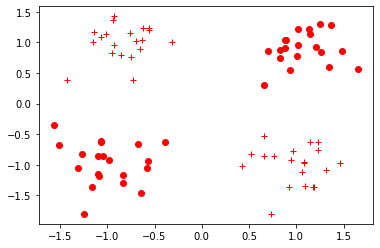

In [6]:
# 데이터가 제대로 만들어지고 레이블링 되었는지 확인하기
# 질문하기

def vis_data(x,y = None, c = 'r'):
    if y is None :
        y = [None] * len(x)
    for x_,y_ in zip(x,y):
        if y_ is None:
            plt.plot(x_[0],x_[1], '*', markerfacecolor = 'none', markeredgecolor = c)
        else: 
            plt.plot(x_[0],x_[1], c+'o' if y_ == 0 else c+'+')
            
plt.figure()
vis_data(x_train, y_train , c= 'r')
plt.show()

In [7]:
# 생성한 넘파이 벡터 형식 데이터 -> 파이토치 텐서
x_train = torch.FloatTensor(x_train)
y_train = torch.FloatTensor(y_train)
x_test = torch.FloatTensor(x_test)
y_test = torch.FloatTensor(y_test)

In [8]:
# (데이터 준비했으니)신경망 모델 구현하기
class NeuralNet(torch.nn.Module):  #nn.module을 상속받아 파이토치 프레임워크에 있는 각종 도구 쉽게 적용 가능
    def __init__(self, input_size, hidden_size):  # 파이썬 객체가 갖는 속성값 초기화
        super(NeuralNet, self). __init__() # super()부르면 우리가 만든 클래스가 파이토치의 nn.module 클래스 가지고 초기화됨
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.linear_1 = torch.nn.Linear(self.input_size, self.hidden_size) #행렬곱과 편향을 포함하는 연산을 지원하는 객체를 반환 (y=ax+b를 만드는 과정이라고 생각)
        self.relu = torch.nn.ReLU() # 활성화 함수
        self.linear_2 = torch.nn.Linear(self.hidden_size, 1)
        self.sigmoid = torch.nn.Sigmoid() # 활성화 함수
        
    def forward(self, input_tensor): # init()에서 정의한 동작들을 차례대로 실행함
        linear1 = self.linear_1(input_tensor)
        relu = self.relu(linear1)
        linear2 = self.linear_2(relu)
        output = self.sigmoid(linear2)
        return output

In [9]:
# 신경망 객체 생성하고 학습에 필요한 여러 변수와 알고리즘 정의하기

model = NeuralNet(2,5) #input_size를 2, hidden_size를 5로 설정한 신경망 객체 model 만듦
learning_rate = 0.03
criterion = torch.nn.BCELoss()  #파이토치가 제공하는 오차함수 이진 교차 엔트로피(BCELoss)
epochs = 2000 # 전체 학습 데이터를 총 몇 번 모델에 입력할지 결정하는 변수
optimizer = torch.optim.SGD(model.parameters(),lr = learning_rate) # 학습에 사용할 최적화 알고리즘 - 확률적 경사하강법 , optimizer은 step()함수를 부를 때 마다 가중치를 학습률만큼 갱신

In [10]:
# 학습하지 않은 모델 성능 시험하기

model.eval()
test_loss_before = criterion(model(x_test).squeeze(), y_test) # 모델의 결과값과 레이블값 차원을 맞춰줘야해서 squeeze함수 호출 후 오차구함. 왜?
print('before training , test loss is {}'.format(test_loss_before.item())) # item은 텐서 속의 숫자 -> 스칼라 값 반환

before training , test loss is 0.7099459171295166


In [11]:
# 신경망 학습하기

for epoch in range(epochs):
    model.train()  # 모델을 학습모드로 바꿈
    optimizer.zero_grad()  # 에폭마다 새로운 경사값을 계산할거니까 zero_grad호출해 경사값을 0으로 설정함
    train_output = model(x_train)  # 생성한 모델에 학습 데이터 입력해 결과값 계산
    train_loss = criterion(train_output.squeeze(), y_train) # 결과값의 차원을 레이블 차원과 같게 만들고 오차 계산
    if epoch % 100 == 0 :
        print('train loss at {} is {}'.format(epoch, train_loss.item()))
    train_loss.backward()  # 오차함수를 가중치로 미분해 오차가 최소가 되는 방향을 구하고 학습률만큼 이동
    optimizer.step()  

train loss at 0 is 0.6977884769439697
train loss at 100 is 0.6543264389038086
train loss at 200 is 0.5929738879203796
train loss at 300 is 0.5017960071563721
train loss at 400 is 0.40626248717308044
train loss at 500 is 0.3210301697254181
train loss at 600 is 0.25715330243110657
train loss at 700 is 0.21106049418449402
train loss at 800 is 0.1776110976934433
train loss at 900 is 0.15278200805187225
train loss at 1000 is 0.13359685242176056
train loss at 1100 is 0.11814453452825546
train loss at 1200 is 0.10547518730163574
train loss at 1300 is 0.09504612535238266
train loss at 1400 is 0.08642672747373581
train loss at 1500 is 0.07913216203451157
train loss at 1600 is 0.0728963166475296
train loss at 1700 is 0.06751322746276855
train loss at 1800 is 0.06283631920814514
train loss at 1900 is 0.05873226001858711


In [12]:
# 학습된 신경망 성능 시험하기

model.eval()
test_loss = criterion(torch.squeeze(model(x_test)),y_test)
print('after training , test loss is {}'.format(test_loss.item()))

after training , test loss is 0.04446306824684143


In [13]:
# 학습된 모델을 .pt파일로 저장하기, 코드 실행하면 학습된 신경망의 가중치 담은 model.pt파일이 생성됨

torch.save(model.state_dict(), './model.pt')
print('state_dict format of the model: {}'.format(model.state_dict()))

state_dict format of the model: OrderedDict([('linear_1.weight', tensor([[-0.1515,  0.3553],
        [-2.1386, -1.1395],
        [ 0.2110,  0.6988],
        [-1.5383,  1.6194],
        [ 1.1865,  1.9259]])), ('linear_1.bias', tensor([ 0.4168, -0.1236, -0.5923, -0.0491,  0.0088])), ('linear_2.weight', tensor([[-0.2294, -2.2551, -0.2395,  2.0664, -2.1044]])), ('linear_2.bias', tensor([2.0741]))])


In [14]:
# 위의 파일을 읽어들여 새로운 신경망 객체에 이미 학습된 모델의 가중치를 바로 적용할 수 있음

new_model = NeuralNet(2,5)
new_model.load_state_dict(torch.load('./model.pt'))
new_model.eval()
print('벡터 [-1,1]이 레이블 1을 가질 확률은 {}'.format(new_model(torch.FloatTensor([-1,1])).item()))

벡터 [-1,1]이 레이블 1을 가질 확률은 0.9913105964660645
